In [2]:
%matplotlib

import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import warnings

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:
data_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\machine-learning-projects\data\astronomical-object')
feature_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\machine-learning-projects\build\feature')
val_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\machine-learning-projects\build\val')
tst_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\machine-learning-projects\build\tst')
sub_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\machine-learning-projects\build\sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'train.csv'
sample_file = sub_dir / 'sample_submission.csv'

target_col = 'type'
n_fold = 5
n_class = 19
seed = 42

In [4]:
algo_name = 'lgbcv' #lgiht gbm cv
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [5]:
df = pd.read_csv(feature_file, index_col = 0)
print(df.shape)
df.shape

(210000, 21)


(210000, 21)

In [6]:
y = df[target_col].values[:199991]
df.drop(target_col, axis = 1, inplace=True)
trn = df.iloc[:199991].values
tst = df.iloc[199991:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(199991,) (199991, 20) (10009, 20)


In [7]:
# Stratified K-Fold Cross Validation

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [9]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))

for i, (i_trn, i_val) in enumerate(cv.split(trn, y),1):
  print(f'training model for CV #{i}')
  clf = lgb.LGBMClassifier(objective = 'multiclass',
                           n_estimators=1000,
                           num_leaves=64,
                           learning_rate=0.1,
                           min_child_samples=10,
                           subsample=.5,
                           subsample_freq=1,
                           colsample_bytree=.8,
                           random_state=seed,
                           n_jobs=-1)
  clf.fit(trn[i_trn], y[i_trn],
          eval_set=[(trn[i_val], y[i_val])],
          eval_metric='multiclass',
          callbacks=[lgb.early_stopping(stopping_rounds=10)])
  
  p_val[i_val, :] = clf.predict_proba(trn[i_val])
  p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 159992, number of used features: 20
[LightGBM] [Info] Start training from score -1.678035
[LightGBM] [Info] Start training from score -1.392665
[LightGBM] [Info] Start training from score -2.615962
[LightGBM] [Info] Start training from score -3.414233
[LightGBM] [Info] Start training from score -2.218194
[LightGBM] [Info] Start training from score -3.760325
[LightGBM] [Info] Start training from score -3.333781
[LightGBM] [Info] Start training from score -8.091059
[LightGBM] [Info] Start training from score -4.357772
[LightGBM] [Info] Start training from score -7.367759
[LightGBM] [Info] Start training from score -2.615193
[LightGBM] [Info] Start training from score -2.695578
[LightGBM] [Info] Start training from

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f'{accuracy_score(y_encoded, np.argmax(p_val, axis=1))*100:.4f}%') 

85.1298%


In [11]:
print(p_val.shape, p_tst.shape)

(199991, 19) (10009, 19)


In [12]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<Axes: ylabel='feature'>

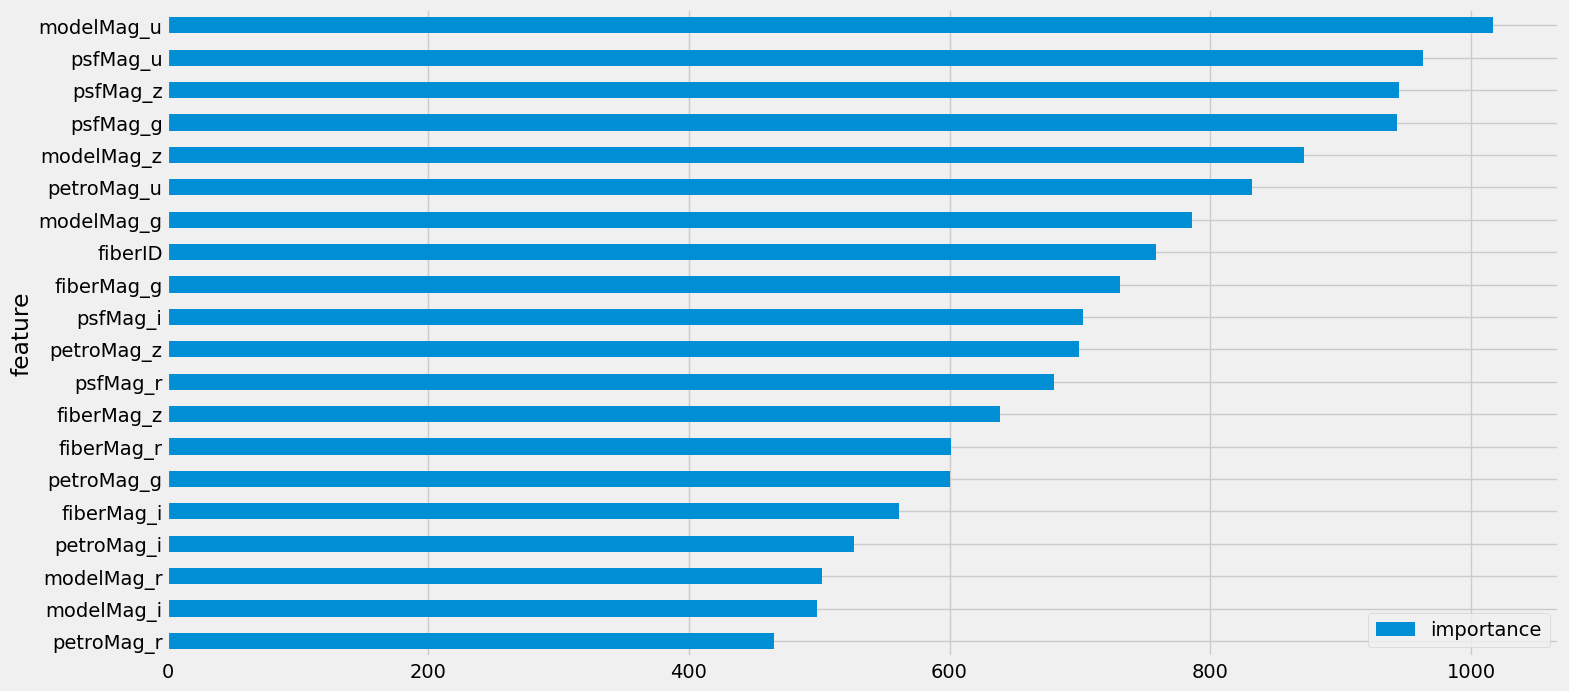

In [13]:
imp = pd.DataFrame({'feature':df.columns, 'importance':clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [14]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(10009, 19)


,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
id,,,,,,,,,,,,,,,,,,,
199991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
sub_col = sub.columns.tolist()
sub[sub_col] = p_tst
print(sub_col)

['STAR_WHITE_DWARF', 'STAR_CATY_VAR', 'STAR_BROWN_DWARF', 'SERENDIPITY_RED', 'REDDEN_STD', 'STAR_BHB', 'GALAXY', 'SERENDIPITY_DISTANT', 'QSO', 'SKY', 'STAR_RED_DWARF', 'ROSAT_D', 'STAR_PN', 'SERENDIPITY_FIRST', 'STAR_CARBON', 'SPECTROPHOTO_STD', 'STAR_SUB_DWARF', 'SERENDIPITY_MANUAL', 'SERENDIPITY_BLUE']


In [16]:
print(clf.classes_)

['GALAXY' 'QSO' 'REDDEN_STD' 'ROSAT_D' 'SERENDIPITY_BLUE'
 'SERENDIPITY_DISTANT' 'SERENDIPITY_FIRST' 'SERENDIPITY_MANUAL'
 'SERENDIPITY_RED' 'SKY' 'SPECTROPHOTO_STD' 'STAR_BHB' 'STAR_BROWN_DWARF'
 'STAR_CARBON' 'STAR_CATY_VAR' 'STAR_PN' 'STAR_RED_DWARF' 'STAR_SUB_DWARF'
 'STAR_WHITE_DWARF']


In [21]:
# clf.classes_ 기준 열 순서 -> sub.columns 기준 열 순서로 인덱스 찾기

idx = [list(clf.classes_).index(col) for col in sub_col]

p_tst_ordered = p_tst[:, idx]

sub[sub.columns] = p_tst_ordered

In [22]:
sub.head()

,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
id,,,,,,,,,,,,,,,,,,,
199991,0.0012,0.0034,0.0002,0.1432,0.0074,0.0070,0.0185,0.0026,0.0250,6.6844e-05,0.5617,0.0047,6.3692e-06,0.0039,0.0018,0.0074,0.0007,2.0000e-01,0.0113
199992,0.0030,0.0085,0.0006,0.0034,0.0184,0.0172,0.0475,0.0072,0.3580,1.6595e-04,0.0176,0.2969,1.5965e-05,0.1690,0.0043,0.0184,0.0015,1.3537e-05,0.0282
199993,0.0021,0.0051,0.0004,0.0020,0.0110,0.0104,0.8737,0.0038,0.0374,9.8411e-05,0.0103,0.0064,1.0045e-05,0.0057,0.0031,0.0109,0.0009,3.1784e-05,0.0167
199994,0.0023,0.0067,0.0005,0.0027,0.0144,0.0135,0.0347,0.0098,0.1141,1.2977e-04,0.0136,0.0163,1.0643e-05,0.0166,0.0034,0.0144,0.0011,3.0096e-05,0.7357
199995,0.0017,0.0048,0.0003,0.0030,0.0104,0.0098,0.0256,0.0036,0.0373,9.4000e-05,0.8589,0.0093,9.0579e-06,0.0058,0.0024,0.0104,0.0008,5.2519e-08,0.0157


In [23]:
sub.to_csv(sub_file)